In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import nlopt
import fem2d as fe

Example : topology optimization of MBB beam using SIMP paradigm, minimal compliance under a volume constraint

Beginning mesh generation...
Mesh generated!


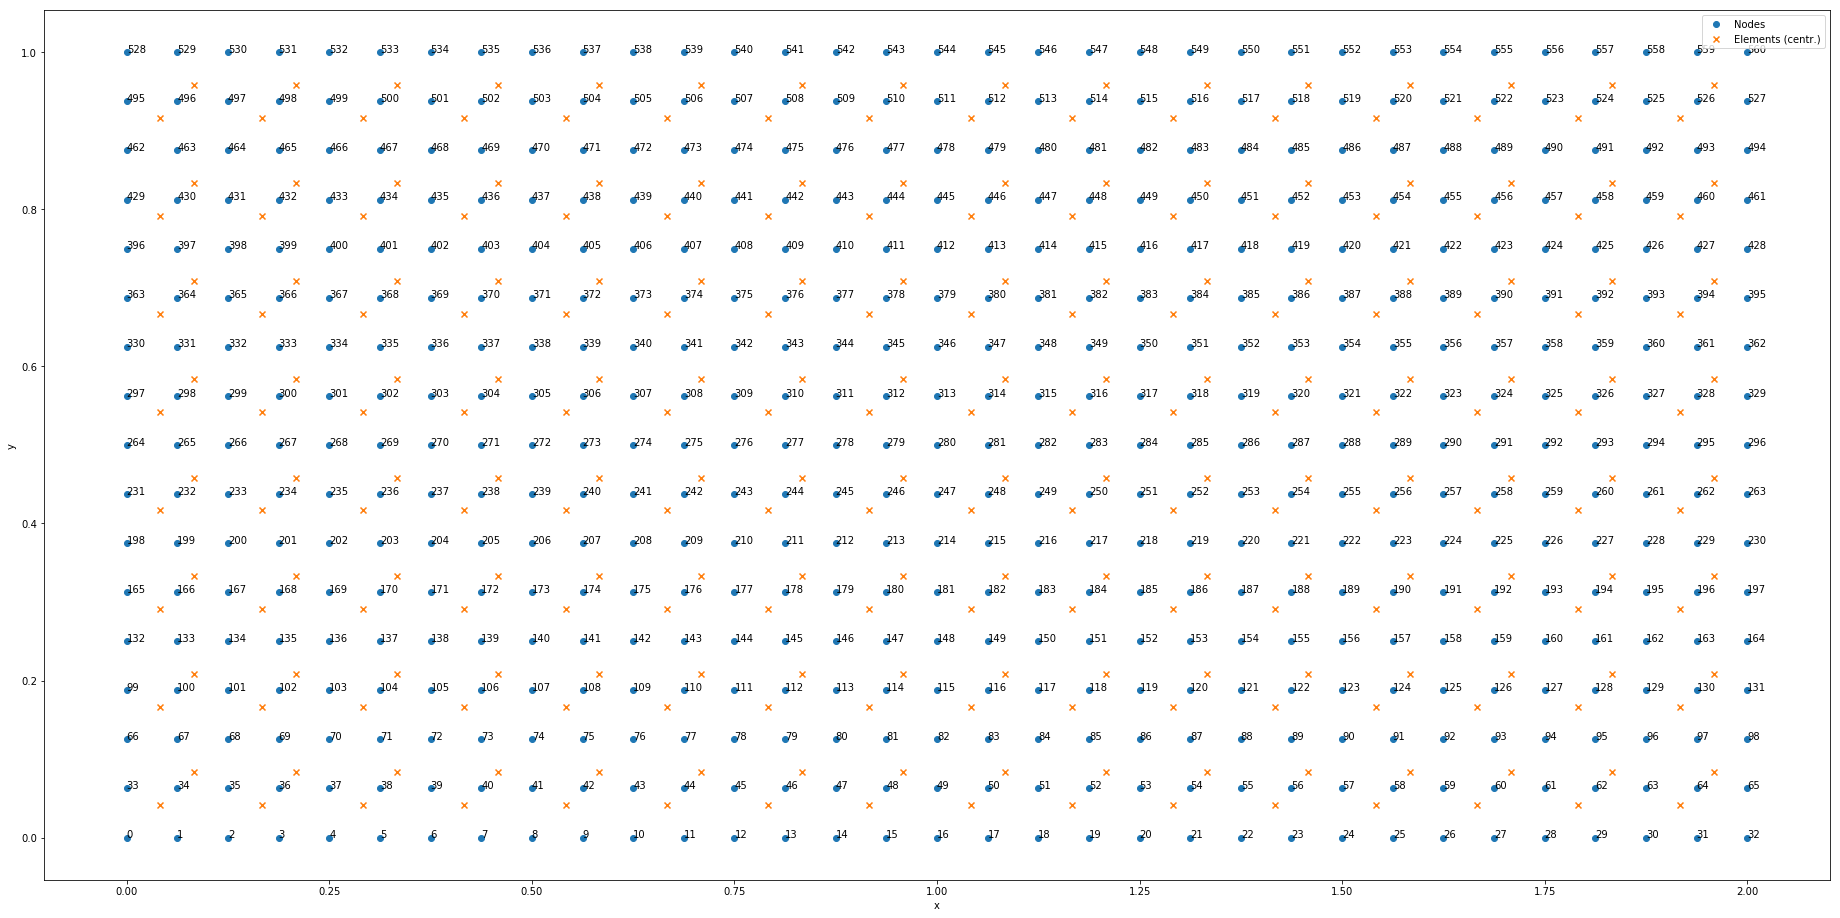

In [3]:
nx = 16
ny = 8
mesh = fe.Mesh(nx, ny)
nelem = mesh.getNelems()
nddl = mesh.getNddlsVec()
refElem = fe.RefElement(mesh)
mesh.displayMesh()

Initialize the finite element problem

In [4]:
# Boundary conditions
dirichletnodes = np.sort(list(range(0,mesh.getNnodes(),2*nx+1)))
dirichletddls = np.sort(mesh.getDDLnumerVec()[dirichletnodes,:].flatten())
ess = np.zeros_like(dirichletddls)
neumannnodes = np.array([65,98,131,164])
neumannddls = np.sort(mesh.getDDLnumerVec()[neumannnodes,:].flatten())
nat = np.array([0,-0.1,0,-0.1,0,-0.1,0,-0.1])

# Declare elasticity problem
elas_solver = fe.Problem(mesh,2)
elas_solver.setDirichletBC(dirichletddls,ess)
elas_solver.setNeumannBC(neumannddls,nat)
DivSigmaU = fe.ElasticityTerm(refElem,nelem)
elas_solver.addTerm(DivSigmaU)

Initialize optimization problem

In [5]:
# Determine fixed DOFs
fixed = np.sort(list(np.arange(0,nelem,2*nx))+list(np.arange(0,nelem,2*nx)+1)+[30,31,62,63,94,95])#pour 16x8
free = np.ones(nelem)
free[fixed] = 0
free = np.arange(nelem)[free.astype("bool")].astype("int")
d = free.shape[0]

# Declare constraint + objective
def c(x, grad):
    grad[:] = (0.5*(1/ny)**2)*np.ones(d)
    rho = np.ones(nelem)
    rho[free] = x
    print(f"Vol = {np.dot((0.5*(1/ny)**2)*np.ones(nelem),rho)}")
    return np.dot((0.5*(1/ny)**2)*np.ones(nelem),rho) - 1.2

def J(x, grad):
    print(f"Gradient shape = {grad.shape}")
    rho = np.ones(nelem)
    rho[free] = x
    DivSigmaU.setParams(100*rho**3,0.3)
    U=elas_solver.solve()
    print("Beginning gradient assembly...")
    Kelem = elas_solver.getCurrentElemMat()
    #gradc = np.zeros(d)
    #valc = c(x,gradc)
    #r=100
    for i in range(d):
        grad[i] = -(3/(2*rho[free[i]]))*Kelem[:,nddl*free[i]:nddl*(free[i]+1)].dot(U).dot(U) #+ r*valc*gradc[i]
    print("Gradient done!")
    print(f"J = {0.5*elas_solver.getCurrentMatrix().dot(U).dot(U)}")
    return 0.5*elas_solver.getCurrentMatrix().dot(U).dot(U) #+ r*valc**2/2


# Declare optimization solver (MMA from NLopt)
optim_solver = nlopt.opt(nlopt.LD_MMA, d)
optim_solver.set_min_objective(J)
optim_solver.set_lower_bounds(1e-4*np.ones(d))
optim_solver.set_upper_bounds(np.ones(d))
optim_solver.add_inequality_constraint(c)
optim_solver.set_param("verbosity",2)
#solver.set_stopval(1e25)
optim_solver.set_maxeval(100)
optim_solver.set_xtol_abs(1e-10)



Solve the optimization problem and visualize the resulting topology

Gradient shape = (234,)
Beginning assembly...
Assembly done!
Elementary matrices validation...
Matrices validated!
Beginning solving...
condA=702980.6408257373
residual=2.1370439273195722e-14
Solved!
Beginning gradient assembly...
Gradient done!
J = 0.0015961980795441884
Vol = 0.9031250000000002
Gradient shape = (234,)
Beginning assembly...
Assembly done!
Elementary matrices validation...
Matrices validated!
Beginning solving...
condA=702815.6912078145
residual=2.3666719459774136e-14
Solved!
Beginning gradient assembly...
Gradient done!
J = 0.0015958547906111818
Vol = 0.9031479886730027
Gradient shape = (234,)
Beginning assembly...
Assembly done!
Elementary matrices validation...
Matrices validated!
Beginning solving...
condA=701173.0346369134
residual=2.6421562536159373e-14
Solved!
Beginning gradient assembly...
Gradient done!
J = 0.0015924354915058522
Vol = 0.9033775675179416
Gradient shape = (234,)
Beginning assembly...
Assembly done!
Elementary matrices validation...
Matrices valid

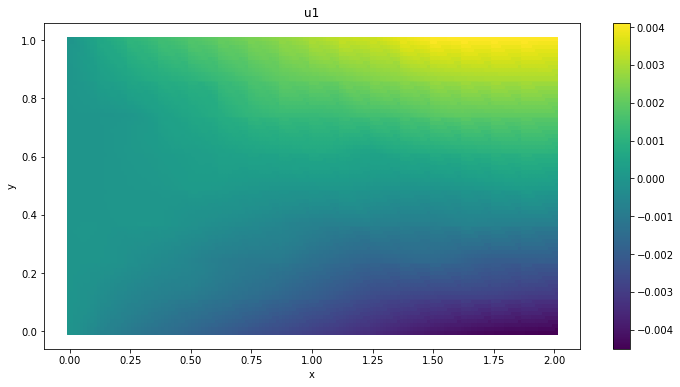

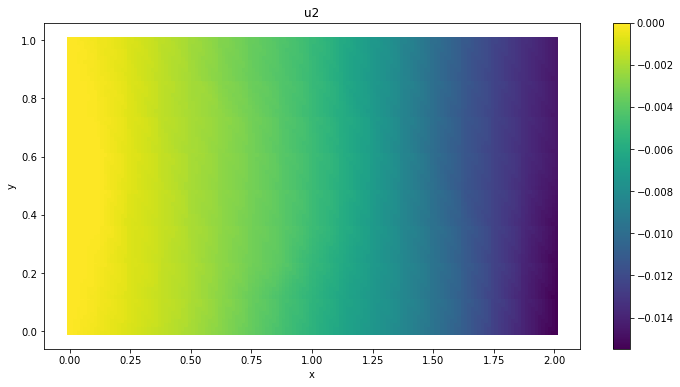

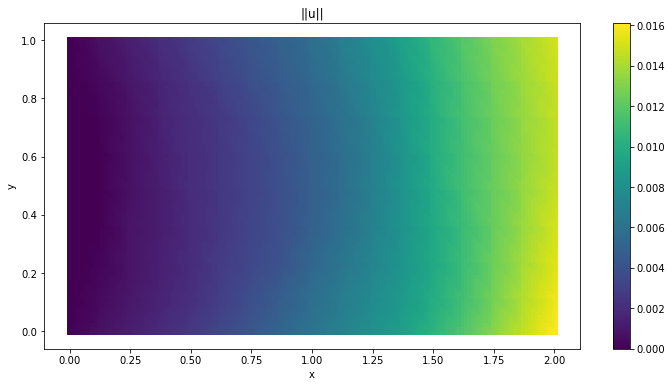

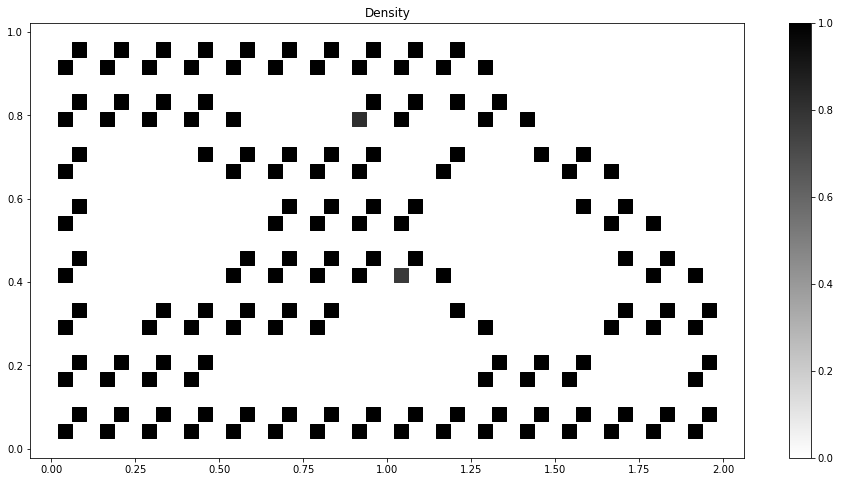

In [6]:
sol = optim_solver.optimize(0.4*np.ones(d))
result = optim_solver.last_optimize_result(); # 1 = success, 2 = values over the max value, 4 = xtol conv
print(f"Exit code = {result}")
print(f"Neval J = {optim_solver.get_numevals()}")

# View resulting displacement
rho = np.ones(nelem)
rho[free] = sol
DivSigmaU.setParams(100*rho**3,0.3)
U=elas_solver.solve()
refElem.displaySolution(U,10,2)

# View design
def displayDesign(sol):
    dens = np.ones(nelem)
    dens[free] = sol
    coords = mesh.getElemCentr()
    plt.figure(figsize=(16,8))
    plt.set_cmap("gray_r")
    plt.scatter(coords[:,0], coords[:,1],c=dens,marker="s",vmin=0,vmax=1,s=200)
    plt.colorbar()
    plt.title("Density")
    plt.show()

displayDesign(sol)

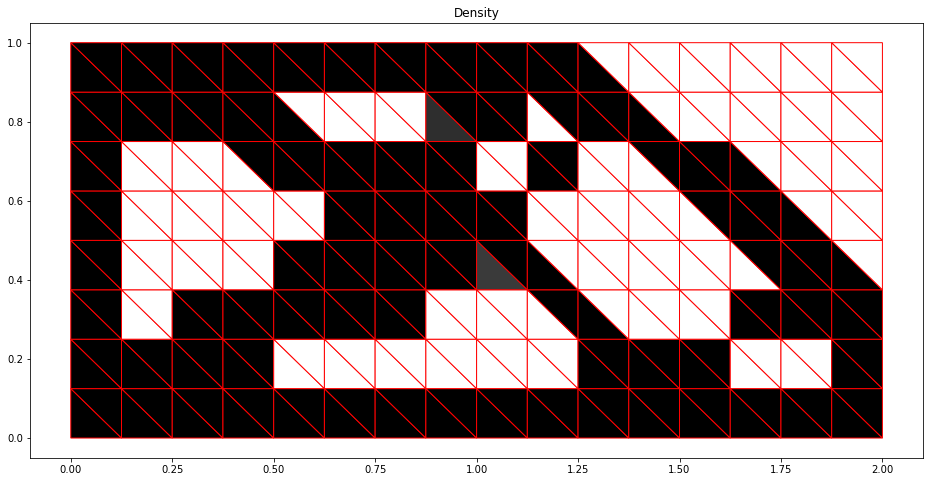

In [14]:
def displayDesignTri(sol):
    dens = np.ones(nelem)
    dens[free] = sol
    vertices = mesh.getElemNodes()[:,:3]
    coords = mesh.getNodeCoord()
    plt.figure(figsize=(16,8))
    for i in range(nelem):
        cv = coords[vertices[i,:]]
        plt.fill(cv[:,0],cv[:,1],facecolor=(1-dens[i],1-dens[i],1-dens[i]),edgecolor="r",linewidth=1)
    plt.title("Density")
    plt.show()

displayDesignTri(sol)